In [1]:
# Run this first!!!
from IPython.display import display, HTML

from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.stats import pearsonr
import random

import sys
sys.path.append('../experimental')
import upper_bound
sys.path.append('../common')
import util
import common_probs
from sampler import DepthSampler
from sampling_misc import sample_failure_depth_size_trend

## Evaluating Signature Upper Bound

First we should see if the upper bound based on the "failure chain signature" is worth exploring further. It turns out that we can do the following upper bound:

$$
S_{n + 1} \leq \sum_{k = 1}^n 2^{\sum_{j < k} \mathbb{1}\left(G[1:k] == G[n-k:k] \textrm{ and } G[1:j] == G[n-j:j]\right)}
$$

Why is this the case? This upper bound accounts for a failure possibly going back to depth $k$ and then counts all the possible depths that can be in the failure chain signature. Since we could possibly have any subset of this, we do 2 raised to this quantity.

Below I simulated this upper bound along with the actual depth sizes. However, we find that this upper bound performs extremely poorly and should probably not be explored more.

In [2]:
def sample(probs, length, num_samples):
    ds = DepthSampler(probs, length)
    return ds.draw_samples(num_samples, ['states', 'threads'])

def plot_states(probs, length, num_samples):
    df = sample(probs, length, num_samples)
    states = df.groupby('depth')['states'].mean().tolist()
    depths = range(length + 1)
    plt.plot(depths, states)
    uppers = upper_bound.average_signature_bound(probs, num_samples, length)
    plt.plot(depths, uppers)
    plt.xlabel('Depth')
    plt.ylabel('Average Number of States')
    plt.title('Average Number of States vs Depth')
    plt.show()

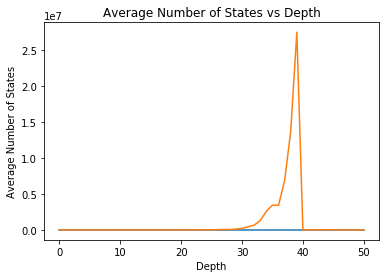

In [6]:
PROBS = [0.25, 0.5, 0.7, 0.3]
DEPTH = 50
NUM_SAMPLES = 10000

plot_states(PROBS, DEPTH, NUM_SAMPLES)

## Correlation Between $S_k$ and Failure to Depth $k$

Going back to the other model that was being looked at, it turns out that it could be possible to prove under a certain lattice (partially ordered set with unique lower bounds/upper bounds) that assuming independence over expectations would actually result in an upper bound if the two things we are measuring are negatively correlated. Some other intuition about this follows from

$$
E[X]E[Y] + Cov(X, Y) = E[XY]
$$

Thus we want Cov(X,Y) to be negative (i.e. negatively correlated). I started trying to think of potentially good latices to do this (it seems like best would be to continue latices in terms of generalized strings not DFAs). However, upon further thought, it seems that size of depth $k$ and whether there is a suffix of length $k$ matching with prefix of length $k$ should always be positively correlated. Some intuition for this is that as we get bigger depth sizes we expect that the number of possible combintations are more "dense" for the first $k$ letters. Thus it is more likely to have a match with a $k$ length suffix.

I did simulations below to test this hypothesis and it seems like it is true that they are positively correlated.

In [18]:
NUM_SAMPLES = 1000
PROBS = [0.5 for _ in range(4)]
DEPTH1 = 3
DEPTH2 = 7

# Get data frame of samples.
df = sample_failure_depth_size_trend(NUM_SAMPLES, PROBS, DEPTH1, DEPTH2)

# Find mean number of states in DEPTH1 conditioned on if
# DEPTH2 has a failure to DEPTH1
print '\n------------Depth Size Conditioned on Has Failure--------------'
print df.groupby('has_failure')['depth_size'].mean()

# Find mean number of states in DEPTH1 conditioned on if
# G[1:DEPTH1] == G[DEPTH2 - DEPTH1:DEPTH1]
print '\n------------Depth Size Conditioned on String Match--------------'
print df.groupby('string_match')['depth_size'].mean()

# Compute expected values and see if we can see a relation.
e_xy = df[df['string_match'] == 1]['depth_size'].mean()
e_x = df['depth_size'].mean()
e_y = df['string_match'].mean()
print '\n------------Expected Values---------------'
print 'E[S_k] = %f ' % e_x
print 'P(G Match) = %f' % e_y
print 'E[S_k] P(G Match) = %f' % (e_x * e_y)
print 'E[S_k and G Match] = %f' % e_xy
print 'E[S_k] P(G Match) - E[S_k and G Match] = %f' % (e_x * e_y - e_xy)


------------Depth Size Conditioned on Has Failure--------------
has_failure
0    1.985047
1    2.387097
Name: depth_size, dtype: float64

------------Depth Size Conditioned on String Match--------------
string_match
False    1.984934
True     2.383795
Name: depth_size, dtype: float64

------------Expected Values---------------
E[S_k] = 2.172000 
P(G Match) = 0.469000
E[S_k] P(G Match) = 1.018668
E[S_k and G Match] = 2.383795
E[S_k] P(G Match) - E[S_k and G Match] = -1.365127


## Correlation Between Depth Size and Offspring Distribution

If we go back to the model before both of these though, there might be quantities that are negatively correlated here that would allow us to apply this trick.

Recall that the relation that I observed before had to do with "threads" where $Z_n$ is the number of threads in a depth. In particular...

$$
Z_{n + 1} = X_{n + 1} + \sum_{m > 0} \sum_{i = 1}^m Y_{i, n} \mathbb{1}\left(Z_n = m\right)
$$

Where $X_n$ is whether there is a new thread at depth $n$ and $Y_{i, n}$ is how many child threads state $i$ in depth $n$ has (also note that each child is only counted once in case we share children). It could be that $Y_{i, n}$ and $Z_n = m$ are negatively correlated because if we have a lot of parents and they have a lot of children then it blows up.

I tested this hypothesis below and it seems like the two might be very slightly negatively correlated. Now we just need to see if we can prove this from a theoretical perspective...

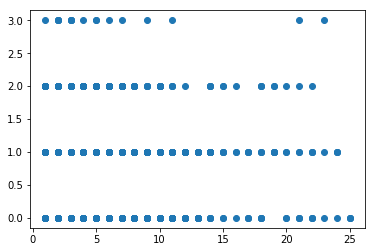

Pearson R Coef: -0.078923
P-Value: 0.016184


In [25]:
NUM_SAMPLES = 1000
PROBS = [0.5 for _ in range(4)]
DEPTH = 20

# Get the dataframe with the samples.
ds = DepthSampler(PROBS, DEPTH + 1)
df = ds.draw_samples(NUM_SAMPLES, ['states', 'thread_children'])

# Get points of (depth size, single thread offspring dist) for DEPTH.
# Remove outliers for depth size.
depth_points = df[np.abs(df['states']-df['states'].mean())<=(3*df['states'].std())]
depth_points = depth_points[depth_points['depth'] == DEPTH]
depth_size = []
offspring_dist = []
for row_ind in xrange(len(depth_points)):
    childrens = depth_points.iloc[row_ind]['thread_children']
    if len(childrens) > 0:
        depth_size.append(depth_points.iloc[row_ind]['states'])
        offspring_dist.append(random.choice(childrens))

# Plot the points to see any visual correlation.
plt.plot(depth_size, offspring_dist, 'o')
plt.show()

# Find Pearson correlation coefficient.
r_coef, p_value = pearsonr(depth_size, offspring_dist)
print 'Pearson R Coef: %f' % r_coef
print 'P-Value: %f' % p_value

## How Could I prove the Above?

The hard part comes now with proving that size of depth $n$ and any given offspring distribution at that depth are negatively correlated. Of course, a formal proof of this would have a distributive lattice and such; however, here are some initial ideas of where to possibly get started.

It might be beneficial to think of everything in terms of languages. Recall that the language of state $s$, $\mathcal{L}(s)$ is the set of all string that allow for us to get to state $s$. I think I also defined before $\mathcal{L}_k(s)$ as the set of strings of length $k$ that take us to $s$. If $s$ is at depth $k$ then these are the strings that take us directly to $s$ without any failure transitions.

Note for the states in depth $k$, $\mathcal{S}_k$, the following is a partition for generalized string prefixes of length $k$.

$$
\cup_{s \in \mathcal{S}_k} \mathcal{L}_k(s)
$$

Let's fix $s \in \mathcal{S}_k$ and think about it. First note that the union of all of $s$'s children's languages will be equal to $\mathcal{L}_k(s) G[k+1]$. If there are a lot of states in depth $k$, it could be that $|\mathcal{L}_k(s)|$. This might imply that $|\mathcal{L}_k(s) G[k+1]|$ is small as well. If this quantity is small, you might not need as many states to cover al of the variation in the set. This is not a solid argument however, since the number of states most likely grows with how many prefixes of size $k$ there are. However, this kind of conceptually tells you why these might be negatively correlated.